Training CNNs *(solution)*
================
------
**Deep Learning for Computer Vision**<br>
(c) Research Group CAMMA, University of Strasbourg<br>
Website: http://camma.u-strasbg.fr/
-----

In this lab session we will go over the detailed implementation of a training loop for a CNN model.

Those *highly repetitive* exercises are meant to train your fundamentals, without the comfort of high-level APIs. 

You will have to identify overfitting scenarios and adjust your training process accordingly using the methods presented during the lecture.

**Instructions**

Import RPS dataset (https://seafile.unistra.fr/f/2d58c54203e6435fbf22/?dl=1) in your google drive 'datasets' folder.

# GPU activation

Be sure to have cuda enabled from your computer.

# Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
from torchvision.transforms import ToTensor, ToPILImage, Resize


import matplotlib.pyplot as plt
import importlib as ipl
import numpy as np
import random
import pickle
import os
import urllib
from timeit import default_timer as timer
import gc
from zipfile import ZipFile

# check the PyTorch version; 
print("PyTorch version: ", torch.__version__)
print("torchvision version: ", torchvision.__version__)

# check the GPU support; shold be yes
print("Is GPU available?: ", torch.cuda.is_available())

PyTorch version:  1.13.1+cpu
torchvision version:  0.14.1+cpu
Is GPU available?:  False


The next cells will prepare the dataset you will be working on.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
filepath='RPS'
with ZipFile('/content/drive/MyDrive/datasets/RPS.zip', 'r') as zf:
  zf.extractall('RPS/')
  print("Files extracted and folder {} created.".format(filepath))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files extracted and folder RPS created.


# Dataset

We will be packaging the data into the following PyTorch datasets with a batch size of 16 for speed and convenience.

In [3]:
filepath='rps'
transform = torchvision.transforms.Compose([
    ToTensor(),
    Resize(size=(224,224)),
])

full_dataset = torchvision.datasets.ImageFolder(root=filepath, transform=transform)
class_names = full_dataset.classes
print(class_names)

items = np.random.permutation(len(full_dataset))
val_ratio = 0.1
test_ratio = 0.1
train_items = items[0:int((1.0-val_ratio-test_ratio)*len(full_dataset))]
val_items = items[int((1.0-val_ratio-test_ratio)*len(full_dataset)):int((1.0-test_ratio)*len(full_dataset))]
test_items = items[int((1.0-test_ratio)*len(full_dataset)):-1]

train_dataset = Subset(full_dataset, train_items)
val_dataset = Subset(full_dataset, val_items)
test_dataset = Subset(full_dataset, test_items)

BATCH_SIZE = 32
full_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_small_indices = np.random.permutation(train_items[0:int(0.05*len(train_items))])
train_small_dataset = Subset(full_dataset, train_small_indices)
train_small_dataloader = DataLoader(train_small_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_small_dataset))
print(next(iter(train_small_dataloader)))

['paper', 'rock', 'scissors']
87
[tensor([[[[0.1771, 0.1784, 0.1831,  ..., 0.3786, 0.3706, 0.3758],
          [0.1711, 0.1768, 0.1775,  ..., 0.2085, 0.2092, 0.2151],
          [0.1723, 0.1750, 0.1760,  ..., 0.1754, 0.1726, 0.1876],
          ...,
          [0.1876, 0.1932, 0.1941,  ..., 0.1984, 0.1917, 0.1915],
          [0.1928, 0.1964, 0.2006,  ..., 0.1941, 0.1915, 0.1922],
          [0.1928, 0.1981, 0.2067,  ..., 0.1867, 0.1981, 0.1961]],

         [[0.5778, 0.5823, 0.5804,  ..., 0.4172, 0.4058, 0.4046],
          [0.5751, 0.5840, 0.5837,  ..., 0.4911, 0.4897, 0.4820],
          [0.5793, 0.5829, 0.5839,  ..., 0.5049, 0.5015, 0.4982],
          ...,
          [0.5891, 0.5971, 0.5980,  ..., 0.6080, 0.6113, 0.6013],
          [0.5967, 0.6003, 0.6029,  ..., 0.6050, 0.6092, 0.6017],
          [0.5967, 0.6020, 0.6006,  ..., 0.6045, 0.6059, 0.6039]],

         [[0.2661, 0.2784, 0.2679,  ..., 0.1753, 0.1706, 0.1725],
          [0.2611, 0.2685, 0.2669,  ..., 0.1791, 0.1804, 0.1830],
        

x, y = dataset[index] 

Labels (y_...) 0, 1, 2 correspond to paper, rock and scissors respectively.
Images (x_...) are (224, 224, 3) numpy arrays.

### TODO 1: Preview 8 images from the training set. Display the type of move (rock, paper or scissors) in the title. Any comments?

Text(0.5, 1.0, "['rock', 'paper', 'scissors', 'scissors', 'scissors', 'paper', 'scissors', 'rock']")

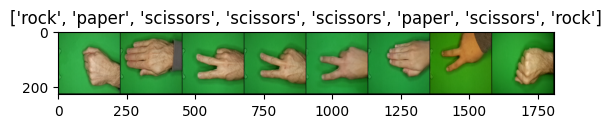

In [4]:
# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:8])

plt.imshow(ToPILImage()(out))
plt.title([class_names[x] for x in classes[0:8]])

# Model

The model is provided in the following cell. Pay attention to the syntax: in *__init__* we define the layers with their properties. In *forward* we establish the sequence of function calls that turns inputs (batch of images) into predictions (batch of class probabilities). Each one of the layer objects behaves like a function.

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.max_pool_1 = nn.MaxPool2d(kernel_size=5)
        self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self._flatten = nn.Flatten()
        self._dense_1 = nn.Linear(in_features=28224, out_features=2048)
        self._dense_2 = nn.Linear(in_features=2048, out_features=4096)
        self._dense_3 = nn.Linear(in_features=4096, out_features=3)
        self._relu = nn.ReLU()
        
    def forward(self, x):
        x = self._relu(self.conv_1(x))
        x = self.max_pool_1(x)
        x = self._relu(self.conv_2(x))
        x = self._flatten(x)
        x = nn.ReLU()(self._dense_1(x))
        x = nn.ReLU()(self._dense_2(x))
        x = self._dense_3(x)
        return x

Here we create a CNN model, as well as a save for its parameters from which you'll restart throughout the lab.

In [6]:
device = 'cpu'
cnn_0 = CNN()
cnn_0 = cnn_0.to(device)
inp = torch.zeros([5,3,224,224]).to(device) # create "fake" input to run cnn_0 a first time, for allocation (starting point)
print(inp.type())
sample = cnn_0(inp)
print(sample)

AssertionError: Torch not compiled with CUDA enabled

Here is an overview of the model's architecture:

In [ ]:
from torchsummary import summary
summary(cnn_0, (3, 224, 224))    # provide "summary" with model and input data size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 220, 220]             608
              ReLU-2          [-1, 8, 220, 220]               0
         MaxPool2d-3            [-1, 8, 44, 44]               0
            Conv2d-4           [-1, 16, 42, 42]           1,168
              ReLU-5           [-1, 16, 42, 42]               0
           Flatten-6                [-1, 28224]               0
            Linear-7                 [-1, 2048]      57,804,800
            Linear-8                 [-1, 4096]       8,392,704
            Linear-9                    [-1, 3]          12,291
Total params: 66,211,571
Trainable params: 66,211,571
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 6.72
Params size (MB): 252.58
Estimated Total Size (MB): 259.87
---------------------------------

This - *incomplete* -  function will be used to complete one training step. For now it takes batch of images *inputs*, the corresponding batch of labels *labels*, a model *cnn_model* and returns the loss between the model's predictions and the labels.

Again, pay attention to the *cnn_model* object. It acts as a **function** here - takes the batch of images and returns the batch of predictions.

In [ ]:
def train_step(inputs, labels, cnn_model):
    cnn_model.train()
    data = inputs.to('cuda:0')
    outp = cnn_model(data)
    loss = torch.mean(torch.nn.CrossEntropyLoss()(outp.to('cpu'), labels)).item()
    del data
    del outp
    torch.cuda.empty_cache()
    return loss

Similarly, the following function computes the accuracy of the model on a batch.

In [ ]:
def eval_step(inputs, labels, cnn_model):
    cnn_model.eval()
    data = inputs.to('cuda:0')
    outp = cnn_model(data)
    pred = torch.argmax(outp, axis=1)
    acc = torch.mean((labels == pred.to('cpu')).float())
    del data
    del pred
    torch.cuda.empty_cache()
    return acc

### TODO 2: Run the model on the training set for 100 iterations. Report the loss at each iteration. Plot and comment; what is missing?

accuracy evaluation on last step : 0.25


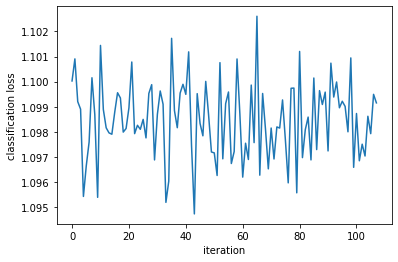

In [ ]:
losses = []
iteration = 0
max_iter = 100

for epoch in range(10):
    for (x_train_in, y_train_in) in train_dataloader:
        iteration += 1 
        losses.append(train_step(x_train_in, y_train_in, cnn_0))
        if iteration >= max_iter:
            break

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(iteration), losses)
ax.set_xlabel("iteration")
ax.set_ylabel("classification loss")

print("accuracy evaluation on last step : {}".format(eval_step(x_train_in, y_train_in, cnn_0)))
torch.cuda.empty_cache()


### TODO 3: Fix the *train_step* function to incorporate the update:
- Compute gradients for all variables in the model
- To each variable, subtract its gradient scaled by a 0.01 learning rate

In [ ]:
LEARNING_RATE = 0.005
optimizer = torch.optim.SGD(cnn_0.parameters(), lr=LEARNING_RATE)

def train_step(inputs, labels, cnn_model, optim):
    cnn_model.train()
    data = inputs.to('cuda:0')
    optim.zero_grad()
    outp = cnn_model(data)
    loss = torch.mean(torch.nn.CrossEntropyLoss()(outp.to('cpu'), labels))
    loss.backward()
    optim.step()
    del data
    del outp
    torch.cuda.empty_cache()
    return loss.item()

In [ ]:
torch.save({
            'model_state_dict': cnn_0.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'start')

### TODO 4: Train the model on the training set for 2000 iterations. Every 100th iteration, report the average loss over the 100 previous iterations. Plot it.

ITER  0: training loss       = 1.0973
______________________________________
ITER  100: training loss       = 1.0967
______________________________________
ITER  200: training loss       = 1.0926
______________________________________
ITER  300: training loss       = 1.0841
______________________________________
ITER  400: training loss       = 1.0592
______________________________________
ITER  500: training loss       = 0.9442
______________________________________
ITER  600: training loss       = 0.6495
______________________________________
ITER  700: training loss       = 0.5018
______________________________________
ITER  800: training loss       = 0.3626
______________________________________
ITER  900: training loss       = 0.2798
______________________________________
ITER  1000: training loss       = 0.2068
______________________________________
ITER  1100: training loss       = 0.1725
______________________________________
ITER  1200: training loss       = 0.1295
___________

Text(0, 0.5, 'classification loss')

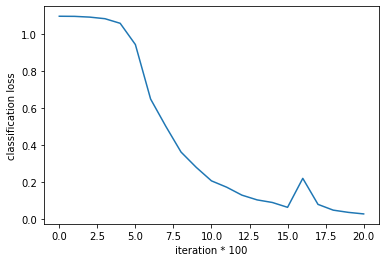

In [ ]:
start_t = timer()

average_training_losses = []
training_losses = []
iteration = 0
nb_pts = 0 
max_iter = 2000
stop_epoch = False

for epoch in range(100): 
    for (x_train_in, y_train_in) in train_dataloader:
        training_losses.append(train_step(x_train_in, y_train_in, cnn_0, optimizer))
        if iteration % 100 == 0:
            nb_pts += 1 
            average_training_losses.append(sum(training_losses) / len(training_losses))
            training_losses = []
            print("ITER  {}: training loss       = {:.4f}".format(iteration, average_training_losses[-1]))
            print("______________________________________")
        if iteration >= max_iter:
            stop_epoch = True
            break
        iteration += 1            
    if stop_epoch:
        break

end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

times = list(range(len(average_training_losses)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(nb_pts), average_training_losses)
ax.set_xlabel("iteration * 100")
ax.set_ylabel("classification loss")

### TODO 5: Evaluate (report the average accuracy) on the training set, then on the test set. Comment.

In [ ]:
train_accs = []
for x_train_in, y_train_in in train_dataloader:
    train_accs.append(eval_step(x_train_in, y_train_in, cnn_0))

average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))

test_accs = []
for x_test_in, y_test_in in test_dataloader:
    test_accs.append(eval_step(x_test_in, y_test_in, cnn_0))

average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc))

ACCURACY - TRAINING SET: 0.9977272748947144
ACCURACY - TEST SET: 0.9498625993728638


### TODO 6: Reset the model's weights, then remove 95% of the data from the training set. Repeat the training process from question 4 on this diminished dataset. Plot the loss, evaluate this model on its training set and the test set. Comment.

In [ ]:
cnn_0 = CNN()
optimizer = optimizer = torch.optim.SGD(cnn_0.parameters(), lr=LEARNING_RATE)

startpoint = torch.load('start')
cnn_0.load_state_dict(startpoint['model_state_dict'])
optimizer.load_state_dict(startpoint['optimizer_state_dict'])
cnn_0 = cnn_0.to('cuda:0')

ITER  0: training loss       = 1.1001
______________________________________
ITER  100: training loss       = 1.0912
______________________________________
ITER  200: training loss       = 1.0818
______________________________________
ITER  300: training loss       = 1.0609
______________________________________
ITER  400: training loss       = 0.9637
______________________________________
ITER  500: training loss       = 0.6814
______________________________________
ITER  600: training loss       = 0.3648
______________________________________
ITER  700: training loss       = 0.1461
______________________________________
ITER  800: training loss       = 0.0331
______________________________________
ITER  900: training loss       = 0.0132
______________________________________
ITER  1000: training loss       = 0.0075
______________________________________
ITER  1100: training loss       = 0.0050
______________________________________
ITER  1200: training loss       = 0.0036
___________

Text(0, 0.5, 'classification loss')

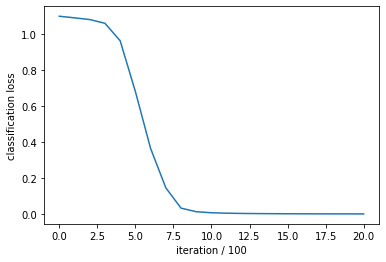

In [ ]:
start_t = timer()

average_training_losses = []
training_losses = []
iteration = 0
nb_pts = 0 
max_iter = 2000
stop_epoch = False

for epoch in range(1000000): 
    for (x_train_in, y_train_in) in train_small_dataloader:
        training_losses.append(train_step(x_train_in, y_train_in, cnn_0, optimizer))
        if iteration % 100 == 0:
            nb_pts += 1 
            average_training_losses.append(sum(training_losses) / len(training_losses))
            training_losses = []
            print("ITER  {}: training loss       = {:.4f}".format(iteration, average_training_losses[-1]))
            print("______________________________________")
        if iteration >= max_iter:
            stop_epoch = True
            break
        iteration += 1
    if stop_epoch:
        break


end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

times = list(range(len(average_training_losses)))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(times, average_training_losses)
ax.set_xlabel("iteration / 100")
ax.set_ylabel("classification loss")

In [ ]:
train_accs = []
for x_train_in, y_train_in in train_small_dataloader:
    train_accs.append(eval_step(x_train_in, y_train_in, cnn_0))

average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))

test_accs = []
for x_test_in, y_test_in in test_dataloader:
    test_accs.append(eval_step(x_test_in, y_test_in, cnn_0))

average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc))

ACCURACY - TRAINING SET: 1.0
ACCURACY - TEST SET: 0.8028846383094788


### TODO 7: We are going to modify the training loop to incorporate validation; every 100th iteration, evaluate the model on the entire validation dataset and report the average accuracy (do this for 0 and 95% of data removed). Plot the validation accuracy over the course of the training process and interpret.

In [ ]:
cnn_0 = CNN()
optimizer = optimizer = torch.optim.SGD(cnn_0.parameters(), lr=LEARNING_RATE)

startpoint = torch.load('start')
cnn_0.load_state_dict(startpoint['model_state_dict'])
optimizer.load_state_dict(startpoint['optimizer_state_dict'])
cnn_0 = cnn_0.to('cuda:0')

ITER  0: training loss       = 1.0915
______________________________________
        : validation accuracy = 0.3484
______________________________________
ITER  100: training loss       = 1.0921
______________________________________
        : validation accuracy = 0.3395
______________________________________
ITER  200: training loss       = 1.0835
______________________________________
        : validation accuracy = 0.6784
______________________________________
ITER  300: training loss       = 1.0555
______________________________________
        : validation accuracy = 0.6310
______________________________________
ITER  400: training loss       = 0.9120
______________________________________
        : validation accuracy = 0.7021
______________________________________
ITER  500: training loss       = 0.6357
______________________________________
        : validation accuracy = 0.7503
______________________________________
ITER  600: training loss       = 0.4892
____________________

Text(0, 0.5, 'validation accuracy')

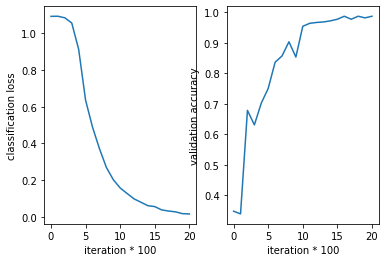

In [ ]:
start_t = timer()

average_training_losses = []
average_val_accs = []
training_losses = []
val_accs = []
iteration = 0
nb_pts = 0 
max_iter = 2000
stop_epoch = False

for epoch in range(100): 
    for (x_train_in, y_train_in) in train_dataloader:
        training_losses.append(train_step(x_train_in, y_train_in, cnn_0, optimizer))
        if iteration % 100 == 0:
            nb_pts += 1 
            average_training_losses.append(sum(training_losses) / len(training_losses))
            training_losses = []
            print("ITER  {}: training loss       = {:.4f}".format(iteration, average_training_losses[-1]))
            print("______________________________________")
            val_accs = []
            for x_val_in, y_val_in in val_dataloader:
                val_accs.append(eval_step(x_val_in, y_val_in, cnn_0))
            average_val_accs.append(sum(val_accs) / len(val_accs))
            print("        : validation accuracy = {:.4f}".format(average_val_accs[-1]))
            print("______________________________________")
        if iteration >= max_iter:
            stop_epoch = True
            break
        iteration += 1
    if stop_epoch:
        break
        
end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

times = list(range(len(average_training_losses)))

fig = plt.figure()

ax = fig.add_subplot(121)
ax.plot(np.arange(nb_pts), average_training_losses)
ax.set_xlabel("iteration * 100")
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
ax.plot(np.arange(len(average_val_accs)), average_val_accs)
ax.set_xlabel("iteration * 100")
ax.set_ylabel("validation accuracy")

In [ ]:
train_accs = []
for x_train_in, y_train_in in train_dataloader:
    train_accs.append(eval_step(x_train_in, y_train_in, cnn_0))

average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))

test_accs = []
for x_test_in, y_test_in in test_dataloader:
    test_accs.append(eval_step(x_test_in, y_test_in, cnn_0))

average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc))

ACCURACY - TRAINING SET: 0.9988636374473572
ACCURACY - TEST SET: 0.9498625993728638


In [ ]:
cnn_0 = CNN()
optimizer = optimizer = torch.optim.SGD(cnn_0.parameters(), lr=LEARNING_RATE)

startpoint = torch.load('start')
cnn_0.load_state_dict(startpoint['model_state_dict'])
optimizer.load_state_dict(startpoint['optimizer_state_dict'])
cnn_0 = cnn_0.to('cuda:0')

ITER  0: training loss       = 1.0983
______________________________________
        : validation accuracy = 0.3325
______________________________________
ITER  100: training loss       = 1.0917
______________________________________
        : validation accuracy = 0.3252
______________________________________
ITER  200: training loss       = 1.0816
______________________________________
        : validation accuracy = 0.3342
______________________________________
ITER  300: training loss       = 1.0605
______________________________________
        : validation accuracy = 0.4580
______________________________________
ITER  400: training loss       = 0.9627
______________________________________
        : validation accuracy = 0.6159
______________________________________
ITER  500: training loss       = 0.6906
______________________________________
        : validation accuracy = 0.7300
______________________________________
ITER  600: training loss       = 0.3640
____________________

Text(0, 0.5, 'validation accuracy')

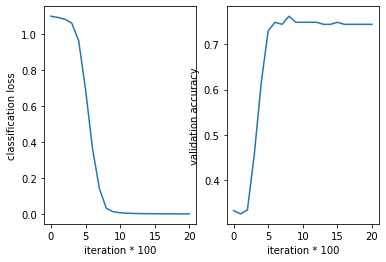

In [ ]:
start_t = timer()

average_training_losses = []
average_val_accs = []
training_losses = []
val_accs = []
iteration = 0
nb_pts = 0 
max_iter = 2000
stop_epoch = False

for epoch in range(1000000): 
    for (x_train_in, y_train_in) in train_small_dataloader:
        training_losses.append(train_step(x_train_in, y_train_in, cnn_0, optimizer))
        if iteration % 100 == 0:
            nb_pts += 1 
            average_training_losses.append(sum(training_losses) / len(training_losses))
            training_losses = []
            print("ITER  {}: training loss       = {:.4f}".format(iteration, average_training_losses[-1]))
            print("______________________________________")
            val_accs = []
            for x_val_in, y_val_in in val_dataloader:
                val_accs.append(eval_step(x_val_in, y_val_in, cnn_0))
            average_val_accs.append(sum(val_accs) / len(val_accs))
            print("        : validation accuracy = {:.4f}".format(average_val_accs[-1]))
            print("______________________________________")
        if iteration >= max_iter:
            stop_epoch = True
            break
        iteration += 1
    if stop_epoch:
        break
        
end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

times = list(range(len(average_training_losses)))

fig = plt.figure()

ax = fig.add_subplot(121)
ax.plot(np.arange(nb_pts), average_training_losses)
ax.set_xlabel("iteration * 100")
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
ax.plot(np.arange(len(average_val_accs)), average_val_accs)
ax.set_xlabel("iteration * 100")
ax.set_ylabel("validation accuracy")

In [ ]:
train_accs = []
for x_train_in, y_train_in in train_small_dataloader:
    train_accs.append(eval_step(x_train_in, y_train_in, cnn_0))

average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))

test_accs = []
for x_test_in, y_test_in in test_dataloader:
    test_accs.append(eval_step(x_test_in, y_test_in, cnn_0))

average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc))

ACCURACY - TRAINING SET: 1.0
ACCURACY - TEST SET: 0.8028846383094788


### TODO 8: We will now incorporate data augmentation into the training set. Choose random transformations in order to return the dataset with randomly transformed images. 

In [ ]:
cnn_0 = CNN()
optimizer = optimizer = torch.optim.SGD(cnn_0.parameters(), lr=LEARNING_RATE)

startpoint = torch.load('start')
cnn_0.load_state_dict(startpoint['model_state_dict'])
optimizer.load_state_dict(startpoint['optimizer_state_dict'])
cnn_0 = cnn_0.to('cuda:0')

In [ ]:
transform_rand = torchvision.transforms.Compose([
    ToTensor(),
    torchvision.transforms.RandomRotation(20),
    Resize(size=(224,224)),
])

full_dataset = torchvision.datasets.ImageFolder(root='RPS', transform=transform_rand)

items = np.random.permutation(len(full_dataset))
val_ratio = 0.1
test_ratio = 0.1
train_items = items[0:int((1.0-val_ratio-test_ratio)*len(full_dataset))]
val_items = items[int((1.0-val_ratio-test_ratio)*len(full_dataset)):int((1.0-test_ratio)*len(full_dataset))]
test_items = items[int((1.0-test_ratio)*len(full_dataset)):-1]

train_dataset = Subset(full_dataset, train_items)
val_dataset = Subset(full_dataset, val_items)
test_dataset = Subset(full_dataset, test_items)

BATCH_SIZE = 32
full_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

ITER  0: training loss       = 1.0980
______________________________________
        : validation accuracy = 0.3414
______________________________________
ITER  100: training loss       = 1.0918
______________________________________
        : validation accuracy = 0.3358
______________________________________
ITER  200: training loss       = 1.0821
______________________________________
        : validation accuracy = 0.3386
______________________________________
ITER  300: training loss       = 1.0606
______________________________________
        : validation accuracy = 0.4686
______________________________________
ITER  400: training loss       = 0.9655
______________________________________
        : validation accuracy = 0.5813
______________________________________
ITER  500: training loss       = 0.6940
______________________________________
        : validation accuracy = 0.6528
______________________________________
ITER  600: training loss       = 0.3557
____________________

Text(0, 0.5, 'validation accuracy')

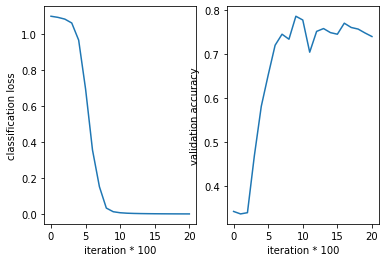

In [ ]:
start_t = timer()

average_training_losses = []
average_val_accs = []
training_losses = []
val_accs = []
iteration = 0
nb_pts = 0 
max_iter = 2000
stop_epoch = False

for epoch in range(1000000): 
    for (x_train_in, y_train_in) in train_small_dataloader:
        training_losses.append(train_step(x_train_in, y_train_in, cnn_0, optimizer))
        if iteration % 100 == 0:
            nb_pts += 1 
            average_training_losses.append(sum(training_losses) / len(training_losses))
            training_losses = []
            print("ITER  {}: training loss       = {:.4f}".format(iteration, average_training_losses[-1]))
            print("______________________________________")
            val_accs = []
            for x_val_in, y_val_in in val_dataloader:
                val_accs.append(eval_step(x_val_in, y_val_in, cnn_0))
            average_val_accs.append(sum(val_accs) / len(val_accs))
            print("        : validation accuracy = {:.4f}".format(average_val_accs[-1]))
            print("______________________________________")
        if iteration >= max_iter:
            stop_epoch = True
            break
        iteration += 1
    if stop_epoch:
        break
        
end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

times = list(range(len(average_training_losses)))

fig = plt.figure()

ax = fig.add_subplot(121)
ax.plot(np.arange(nb_pts), average_training_losses)
ax.set_xlabel("iteration * 100")
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
ax.plot(np.arange(len(average_val_accs)), average_val_accs)
ax.set_xlabel("iteration * 100")
ax.set_ylabel("validation accuracy")

In [ ]:
train_accs = []
for x_train_in, y_train_in in train_small_dataloader:
    train_accs.append(eval_step(x_train_in, y_train_in, cnn_0))

average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))

test_accs = []
for x_test_in, y_test_in in test_dataloader:
    test_accs.append(eval_step(x_test_in, y_test_in, cnn_0))

average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc))

ACCURACY - TRAINING SET: 1.0
ACCURACY - TEST SET: 0.7235576510429382


### TODO 9: We will attempt to use l2 regularization to alleviate the overfitting issue. Use the "weight_decay" in your optimizer. 

Train on the small training set; plot loss and validation accuracy. 

In [ ]:
cnn_0 = CNN()
optimizer = optimizer = torch.optim.SGD(cnn_0.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

startpoint = torch.load('start')
cnn_0.load_state_dict(startpoint['model_state_dict'])
optimizer.load_state_dict(startpoint['optimizer_state_dict'])
cnn_0 = cnn_0.to('cuda:0')

ITER  0: training loss       = 1.1009
______________________________________
        : validation accuracy = 0.3406
______________________________________
ITER  100: training loss       = 1.0921
______________________________________
        : validation accuracy = 0.3333
______________________________________
ITER  200: training loss       = 1.0820
______________________________________
        : validation accuracy = 0.3528
______________________________________
ITER  300: training loss       = 1.0614
______________________________________
        : validation accuracy = 0.4304
______________________________________
ITER  400: training loss       = 0.9662
______________________________________
        : validation accuracy = 0.6443
______________________________________
ITER  500: training loss       = 0.6838
______________________________________
        : validation accuracy = 0.5749
______________________________________
ITER  600: training loss       = 0.3818
____________________

Text(0, 0.5, 'validation accuracy')

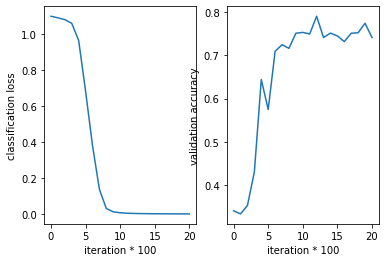

In [ ]:
start_t = timer()

average_training_losses = []
average_val_accs = []
training_losses = []
val_accs = []
iteration = 0
nb_pts = 0 
max_iter = 2000
stop_epoch = False

for epoch in range(1000000): 
    for (x_train_in, y_train_in) in train_small_dataloader:
        training_losses.append(train_step(x_train_in, y_train_in, cnn_0, optimizer))
        if iteration % 100 == 0:
            nb_pts += 1 
            average_training_losses.append(sum(training_losses) / len(training_losses))
            training_losses = []
            print("ITER  {}: training loss       = {:.4f}".format(iteration, average_training_losses[-1]))
            print("______________________________________")
            val_accs = []
            for x_val_in, y_val_in in val_dataloader:
                val_accs.append(eval_step(x_val_in, y_val_in, cnn_0))
            average_val_accs.append(sum(val_accs) / len(val_accs))
            print("        : validation accuracy = {:.4f}".format(average_val_accs[-1]))
            print("______________________________________")
        if iteration >= max_iter:
            stop_epoch = True
            break
        iteration += 1
    if stop_epoch:
        break
        
end_t = timer()
print("time_elapsed: {}".format(end_t - start_t))

times = list(range(len(average_training_losses)))

fig = plt.figure()

ax = fig.add_subplot(121)
ax.plot(np.arange(nb_pts), average_training_losses)
ax.set_xlabel("iteration * 100")
ax.set_ylabel("classification loss")

ax = fig.add_subplot(122)
ax.plot(np.arange(len(average_val_accs)), average_val_accs)
ax.set_xlabel("iteration * 100")
ax.set_ylabel("validation accuracy")

In [ ]:
train_accs = []
for x_train_in, y_train_in in train_small_dataloader:
    train_accs.append(eval_step(x_train_in, y_train_in, cnn_0))

average_train_acc = sum(train_accs) / len(train_accs)
print("ACCURACY - TRAINING SET: {}".format(average_train_acc))

test_accs = []
for x_test_in, y_test_in in test_dataloader:
    test_accs.append(eval_step(x_test_in, y_test_in, cnn_0))

average_test_acc = sum(test_accs) / len(test_accs)
print("ACCURACY - TEST SET: {}".format(average_test_acc))

ACCURACY - TRAINING SET: 1.0
ACCURACY - TEST SET: 0.7201236486434937


### EXTRA QUESTION 1: Change the code for *CNN* by adding dropout, for example between the flatten and dense_1 layers.

### EXTRA QUESTION 2: Repeat the previous experiments with different values for the learning rate and batch size.

### EXTRA QUESTION 3: On the small dataset, save the model when validation accurary is at its highest, and check for test accuracy (early stopping). 

### Theoretical questions to think about:
- What are the advantages and disadvantages of having a large validation set?
- Same question for a small one.
- Why do we even have a validation set at all? Why not directly use the test set?
- Take another look at the model we used. Can you point out any issues with it?
- Manufacturing small examples of overfitting was actually quite challenging. To do this, a certain amount of labels (20% of the training set) had to be corrupted. How does that drive the model into overfitting?